# Part 3A: A Simple Data Analysis

We will use data from the results of Machado et al. introduced on the previous page. I will use just five data points as that is a common number used in the literature (we really should insist on more.) 

## Its Simple

*Python* is not complicated. In this notebook we will become acquainted with how a notebook works and with the architecture of a *Python* program. I have no intention of teaching *Python* here. You can figure out what is happening by looking at the code and reading the comments. You can access the code via Google *Colab* or download this notebook and use it on your own computer with the buttons at the top right of this web page.

Lets dive right in...

## Load the Toolbox

In a *Python* notebook, we can mix code and text. In the code block below are commands to load the libraries and modules we will need for this exercise. There are some special commands that are used to run unix xommands directly in the terminal of *Colab* to install *Python* packages that are not available by default. These can "commented out" if you run this notebook on your own computer. You will need to add the "hashtag" comment symbol. 

In [157]:
### Setup environment

!mkdir plots
!pip install uncertainties              # uncomment to install dependancy

import scipy                             # includes tools for data analysis
import numpy as np                       # import the tools of NumPy as "np"
from matplotlib import pyplot as plt     # tools for plotting
import matplotlib

import uncertainties as un               # for handling uncertain numbers
from uncertainties import unumpy as unp  # a replacement for numpy that uses 
                                         #  uncertainty values

location_data = "data/"         ## Use either local folder or github folder. 
location_styles = "styles/"     ## Use github locations for Colab
#location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
#location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"

size = (4,4)    # size of plots

mkdir: plots: File exists


## The Erying Plot

The code below will take some data that we typed in and perform a linear least-squares fit. The data and the line fit will be plotted. I am using the minimum amount of coding here to emphasize how simple this can be. More complicated examples that follow in upcoming pages are all based on this foundation.

### The Complete Calculation

The code below performs a linear fit to the Eyring plot and the results are printed out. 

In [158]:
### Experimental data
temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = np.array(k_obs)

### Calculations
x = 1/temp
y = np.log(k_obs/temp)

### Line fit using linear regression
fit = scipy.stats.linregress(x,y)
print(fit)                           # fit is a 'object' containing the results

LinregressResult(slope=-5560.074229125674, intercept=15.365177590523832, rvalue=-0.9970033160626764, pvalue=0.00019683392591187597, stderr=249.0767684307886, intercept_stderr=0.8227078340122718)


### The Report

It doesn't matter what you do, you must tell somebody about it. The code below will print out the parameters and statistical information and plot the original data and a line calculated from the fit parameters. The second narrow plot is a plot of the residuals. Always plot the residuals for any curve fit. It may reveal systematic error in your model.



slope = -5560.07+/-249.08
int = 15.37+/-0.82
rsq = 0.994


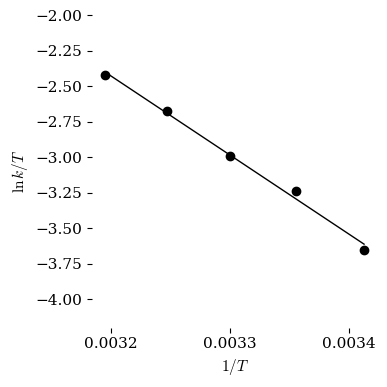

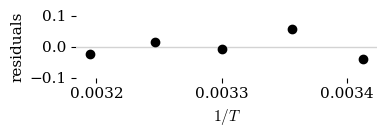

In [159]:
### Assign compnents of the fit result to variables
slope = fit.slope
slope_stderr = fit.stderr 
intercept = fit.intercept
int_stderr = fit.intercept_stderr
rsq = fit.rvalue ** 2

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  
print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"rsq = {rsq:0.3f}")
best_fit_y = slope * x + intercept   # calculate y-values using fit parameters

### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                    # plot data with black circle
plt.plot(x,best_fit_y,"k-")           # plot fit line with black line
plt.xticks([0.0032,0.0033,0.0034])    # there were too many x labels
plt.ylim(-4.2,-2.0)

plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3A-00.pdf")
plt.show()                            # show plot (and clear)

### Plot the residuals
residuals = y - best_fit_y            # difference between data and line-fit
plt.figure(figsize=size).set_figheight(1.5)       # set plot height to 1 inch
plt.axhline(0, color='lightgray')       # plot a horizontal line
plt.plot(x,residuals,"ko")
plt.xticks([0.0032,0.0033,0.0034])    # there were too many x labels
plt.ylim(-.1,.1)
plt.xlabel(r"${1/T}$")
plt.ylabel(r"residuals")

plt.savefig("plots/3A-01.pdf")
plt.show()

## Calculating Thermodynamic Parameters

We performed the Eyring plot analysis to get $\Delta H^\ddagger$ and $\Delta S^\ddagger$ for the reaction in the active site of the enzyme. I can easily calculate the $\Delta H^\ddagger$ and $\Delta S^\ddagger$ from the line fit parameters, but how do I propagate error through the calculation. The line fit algorithm has produced an estimated error expressed as a standard deviation value for both slope and intercept. This error must be correctly translated to the calculated $\Delta H^\ddagger$ and $\Delta S^\ddagger$ values obtained from the uncertain slope and intercept. There are mathematical rules for doing this.

### Uncertain Numbers

Rather than review a statistics testbook, let us use a tool that handles error propagation for us. We will use the ```uncertainties``` module. It provides a data structure called *ufloat*, which is a floating point value with the error included. It is an object that retains information on the uncertainty for the value and its relationship to any other uncertain values with which it has interacted. For example, if I multiply the ufloat values $a$ and $b$ together, it will produce a value that combines the errors. If I divide that answer by $b$ I will not get an answer in which the errors have been combined again, but will get the original $a$ back. The ufoat value knew its history with $b$ and correctly handled the situation.

The code below will create ufloat values from the parameters and their estimated uncertainties. Then we will use these values to calculate the values of $\Delta H^\ddagger$ and $\Delta S^\ddagger$ with errors included. You can see that the estimated errors in the thermodynamic parameters are large.



In [160]:
### Create ufloat objects from fit results
slope_u = un.ufloat(slope,slope_stderr)
intercept_u = un.ufloat(intercept,int_stderr)

### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope_u * R
dS = (intercept_u - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH/1000:0.0f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

The change in enthalpy is 46+/-2 kJ/mole
The change in entropy is -69.80+/-6.84 J/mole.K


## Highly Leveraged

We shall now observe that we have set ourselves up for trouble with the way we are using these errors. The error in the slope has a large effect on the value of the intercept. The values of slope and intercept are strongly coupled in this case. However, the ufloat objects that we created for $\Delta H^\ddagger$ and $\Delta S^\ddagger$ have no connection with each other because we created them seperately from scratch. Consider the example below.

### Check the Confidence Interval

We have the parameters and the estimated errors. We can back-propagate these uncertain values and calculate the rates at the tempertures in the data. The errors determined in the ufloat object will be the "$1\sigma$ confidence interval."  This should be the range where 68% of the values determined at that temperature would be found (one standard deviation in a Gaussian distribution.)

As you can see, the confidence is awful. Our value is garbage. We have no confidence. Did we make a mistake? Yes we did. 

In [161]:
### Calculate the rate constant using the parameters and temperature
### The uncertainty in the parameters will propagate back to the data point

T = 303
k_obs_c = kappa*kb/h * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
print(f"The confidence interval for k_cat at {T} K is {k_obs_c:0.1f} s^-1")

The confidence interval for k_cat at 303 K is 15.3+/-17.8 s^-1


### Plot the Confidence Interval

The uncertain value calculated for $k_{cat}$ is $15.3 \pm 35.6\ s^{-1}$ with a $2\sigma$ confidence (twice the standard deviation will encompass 95.5% of likely outcomes). This is obviously rediculous and represents a nonesense value.

The large error seems incongrous with the quality of the data. Below I will plot the confidence range of the data using $2\sigma$ confidence. Why is the band so wide compared to the scatter of the data? The reason is that we are not using the uncertain values correctly.

slope = -5560.07+/-249.08
The intercept is 15.37+/-0.82

rsq = 0.994


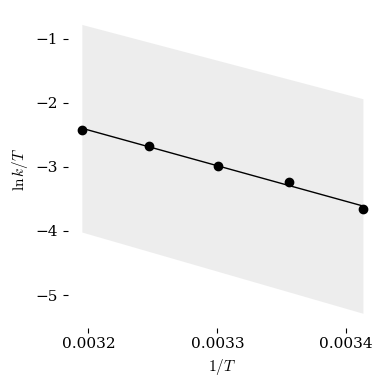

The change in enthalpy is 46229.03+/-2070.94 kJ/mole
The change in entropy is -69.80+/-6.84 J/mole.K
Calculated k at T = 303 K is 15.31+/-17.81 s^-1


In [162]:
### Experimental data
temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = np.array(k_obs)

### Calculations
x = 1/temp
y = np.log(k_obs/temp)

### Remove Lever Arm
x_ave = np.average(x)      # average 1/T value
x_nolever = x      # subtract average 1/T from 1/T values

fit = scipy.stats.linregress(x_nolever,y)

### REPORT
### Assign compnents of the fit result to variables
slope = fit.slope
slope_stderr = fit.stderr 
intercept = fit.intercept
int_stderr = fit.intercept_stderr
rsq = fit.rvalue ** 2

### Create new ufloat objects from fit results
slope_unc = un.ufloat(slope, slope_stderr)
intercept_unc = un.ufloat(intercept, int_stderr)

### calculate the true intercept 
intercept_true = intercept_unc

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  
# print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"The intercept is {intercept_true:0.2f}")
print()
print(f"rsq = {rsq:0.3f}")

#### calculate y-values using best fit parameters
sigma = 1
x_0 = np.linspace(0,np.max(x),100)                


best_fit_y = slope * x + intercept     # ufloat.n gives the nominal value
best_fit_y_upper = (slope-slope_stderr*sigma) * x + (intercept-int_stderr)     # ufloat.n gives the nominal value
best_fit_y_lower = (slope+slope_stderr*sigma) * x + (intercept+int_stderr)     # ufloat.n gives the nominal value


### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                               # plot data with black circle
plt.plot(x,unp.nominal_values(best_fit_y),"k-")  # plot fit line with black line

### Create Confidence band upper and lower bounds

# make filled band
plt.fill_between(x, best_fit_y_upper, best_fit_y_lower, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth = 0, label="confidence interval")

#plt.ylim(-4.2,-1.0)


plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3A-02.pdf")
plt.show()                                       # show plot (and clear)

### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope_unc * R
dS = (intercept_true - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")


### The Lever Arm

Let us plot the entire $x$-axis from zero (where the $y$-intercept is) to our data. You can see that we are a looong distance from the $y$-axis and any small errors in slope will lead to large error in intercept. 

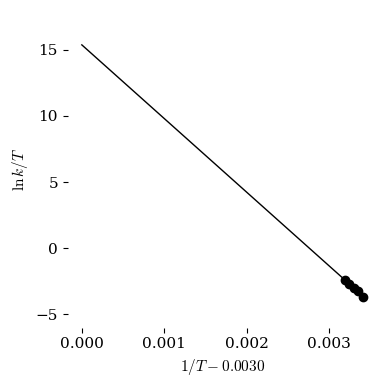

In [163]:
### Plot data and line-fit (cut and pasted from above)
x_0 = np.insert(x,len(x),0)            # insert zero in alst position of x array
best_fit_y_0 = slope * x_0 + intercept # calculate fit starting at zero

plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                     # plot data with black circle
plt.plot(x_0,best_fit_y_0,"k-")        # plot fit line starting at zero
plt.xlabel(r"${1/T}-0.0030$")
plt.ylabel(r"$\ln{k/T}$")
plt.ylim(-6,18)
plt.savefig("plots/3A-03.pdf")
plt.show()                                       


### The Lever Arm with Error

Below is the lever arm plot with the confidence interval calculated from the parameters and their standard deviations. Does this look correct?

We can see that the error band uses the error for the intercept ($15.37 \pm 0.82$) and then from the two outer values for intercept ($16.19$ and $14.55$) we track away at the limits of the slope ($-5560.07 \pm 249.08$). But the data that defined these values should be where the divergence starts, not some distant target at $x=0$.



slope = -5560.07+/-249.08
The true intercept is 15.37+/-0.82

rsq = 0.994


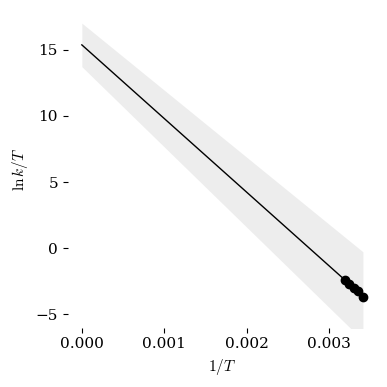

The change in enthalpy is 46229.03+/-2070.94 kJ/mole
The change in entropy is -69.80+/-6.84 J/mole.K
Calculated k at T = 303 K is 15.31+/-17.81 s^-1


In [164]:
### Experimental data
temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = np.array(k_obs)

### Calculations
x = 1/temp
y = np.log(k_obs/temp)

### Remove Lever Arm
x_ave = np.average(x)      # average 1/T value
x_nolever = x      # subtract average 1/T from 1/T values

fit = scipy.stats.linregress(x_nolever,y)

### REPORT
### Assign compnents of the fit result to variables
slope = fit.slope
slope_stderr = fit.stderr 
intercept = fit.intercept
int_stderr = fit.intercept_stderr
rsq = fit.rvalue ** 2

### Create new ufloat objects from fit results
slope_unc = un.ufloat(slope, slope_stderr)
intercept_unc = un.ufloat(intercept, int_stderr)

### calculate the true intercept 
intercept_true = intercept_unc

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  
# print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"The true intercept is {intercept_true:0.2f}")
print()
print(f"rsq = {rsq:0.3f}")

#### calculate y-values using best fit parameters
sigma = 2
x_0 = np.linspace(0,np.max(x),100)                


best_fit_y = slope * x_0 + intercept     # ufloat.n gives the nominal value
best_fit_y_upper = (slope-slope_stderr*sigma) * x_0 + (intercept-int_stderr*sigma)     # ufloat.n gives the nominal value
best_fit_y_lower = (slope+slope_stderr*sigma) * x_0 + (intercept+int_stderr*sigma)     # ufloat.n gives the nominal value


### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                               # plot data with black circle
plt.plot(x_0,best_fit_y,"k-")  # plot fit line with black line

### Create Confidence band upper and lower bounds

# make filled band
plt.fill_between(x_0, best_fit_y_upper, best_fit_y_lower, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth = 0, label="confidence interval")



#plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.ylim(-6,18)

plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3A-04.pdf")
plt.show()                                       # show plot (and clear)


### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope_unc * R
dS = (intercept_true - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")


### Removing the Lever

This problem is easily solved. We need the intercept to be very close to the data so there is no long lever arm. Let is simply subtract the average value for the x-axis data from the data set. Then the intercept will be in the middle of the data and experience the minimum coupling. We can calculate the value of the y-axis at the far flung end of the former lever arm and see that the errors for $\Delta H^\ddagger$ and $\Delta S^\ddagger$ are exactly the same as before. But now the ufloat object for the intercept knows that it has been coupled with the slope because we used the slope value in its calculation (see code below). 

With the coupling (covariance) established, we can repeat the confidence interval calculation and we see a much more reasonable value.

x-offset is 0.00330
slope = -5560.07+/-249.08
int = -2.99+/-0.02
rsq = 0.994


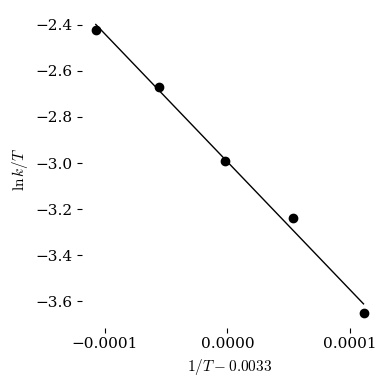

In [165]:
### Remove Lever Arm
x_ave = np.average(x)      # average 1/T value
x_nolever = x - x_ave      # subtract average 1/T from 1/T values

print(f"x-offset is {x_ave:0.5f}")
fit = scipy.stats.linregress(x_nolever,y)

### REPORT
### Assign compnents of the fit result to variables
slope = fit.slope
slope_stderr = fit.stderr 
intercept = fit.intercept
int_stderr = fit.intercept_stderr
rsq = fit.rvalue ** 2

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  # Using "f-string" 
print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"rsq = {rsq:0.3f}")
best_fit_y = slope * x_nolever + intercept  # calc y-values using parameters

### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x_nolever,y,"ko")              # plot data with black circle
plt.plot(x_nolever,best_fit_y,"k-")     # plot fit line with black line
plt.xticks([-0.00010,0,0.0001])         # there were too many x labels
plt.xlabel(r"${1/T}-0.0033$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3A-05.pdf")
plt.show()                              # show plot (and clear)

### Calculating Thermodynamic Parameters Again

We have a value for intercept and its error is very small as it is in the middle of the data set and largely unaffected by any variations in slope. We will now calculate the "true intercept" at $1/T = 0$. In the code below you can see that we are multiplying the slope by the length of the lever arm (the value we subtracted from the $x$-axis) and adding that to the intercept. This will give us the true intercept at the end of the lever arm. The new ufloat object carries within it the knowledge that it was created through the combination of the slope and the intercept. The true intercept value is strongly coupled to slope (we multiplied by a long lever arm to get the value) but the ufloat object now includes this fact within it, somehow.

The values of $\Delta H^\ddagger$ and $\Delta S^\ddagger$ are derived from the strongly coupled slope and true intercept values. As a result, they are also strongly coupled but the ufloat objects will continue to track that covariance within them. When we use these values to calculate the $k_{cat}$ value we see that the estimated error is correct.

In [166]:
### Create new ufloat objects from fit results
slope_unc = un.ufloat(slope, slope_stderr)
intercept_unc = un.ufloat(intercept, int_stderr)

### calculate the true intercept 
# NOTE: intercept_true is the result of slope_unc. the ufloat will 
#  now contain the correlation between intercept_true and slope_unc

intercept_true = intercept_unc - slope_unc * x_ave
print(f"The true intercept is {intercept_true:0.2f}")
print()

### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope_unc * R
dS = (intercept_true - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print()
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")


The true intercept is 15.37+/-0.82

The change in enthalpy is 46229.03+/-2070.94 kJ/mole
The change in entropy is -69.80+/-6.84 J/mole.K

Calculated k at T = 303 K is 15.31+/-0.29 s^-1


## Plot the Confidence Band

Now that we have values for $\Delta H^\ddagger$ and $\Delta S^\ddagger$ that are represented by coupled ufloat objects, we can use them to calculate the confidence interval at every $x$-value and plot the fit and the "confidence band." The usual practice is to plot the 95% confidence interval, which is $2\sigma$ or twice the standard deviation.

In the code below you will see ways to separate the nominal value and the error values out of a ufloat object. The ```matplotlib.pyplot``` library cannot use ufloat values. The code below is also "complete." I will be repeating many elements that have already been assigned above so that this block of code can be cut and pasted in its entirety and used in your own work.

### Band Calculated from Uncertain $\Delta H^\ddagger$ and $\Delta S^\ddagger$ 

We can calculate the confidence band for the Erying plot by using the uncertain values for $\Delta H^\ddagger$ and $\Delta S^\ddagger$ to get an uncertain value for $k_{cat}$. We then calculate the y-axis of $\ln\left( k_{cat}/T\right)$ as an uncertain number. Add and subtract the $\pm$ error to get the confidence band.

slope = -5560.07+/-249.08
The true intercept is 15.37+/-0.82

rsq = 0.994


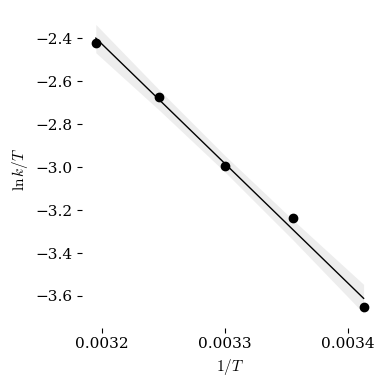

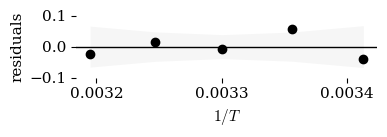

The change in enthalpy is 46229.03+/-2070.94 kJ/mole
The change in entropy is -69.80+/-6.84 J/mole.K
15.31+/-0.29
Calculated k at T = 303 K is 15.31+/-0.29 s^-1


In [167]:
### Experimental data
temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = np.array(k_obs)

### Calculations
x = 1/temp
y = np.log(k_obs/temp)

### Remove Lever Arm
x_ave = np.average(x)      # average 1/T value
x_nolever = x - x_ave      # subtract average 1/T from 1/T values

fit = scipy.stats.linregress(x_nolever,y)

### REPORT
### Assign compnents of the fit result to variables
slope = fit.slope
slope_stderr = fit.stderr 
intercept = fit.intercept
int_stderr = fit.intercept_stderr
rsq = fit.rvalue ** 2

### Create new ufloat objects from fit results
slope_unc = un.ufloat(slope, slope_stderr)
intercept_unc = un.ufloat(intercept, int_stderr)

### calculate the true intercept 
intercept_true = intercept_unc - slope_unc * x_ave

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  
# print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"The true intercept is {intercept_true:0.2f}")
print()
print(f"rsq = {rsq:0.3f}")

#### calculate y-values using best fit parameters
best_fit_y = slope * x + intercept_true     # ufloat.n gives the nominal value


### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                               # plot data with black circle
plt.plot(x,unp.nominal_values(best_fit_y),"k-")  # plot fit line with black line

### Create Confidence band upper and lower bounds
sigma = 2

# create array of uncertain values for kobs
kobs = (kappa * kb / h) * temp * unp.exp(-dH/(R*temp)) * unp.exp(dS/R)

# upper and lower bounds of uncertain kobs as float values
k_up = unp.nominal_values(kobs) + unp.std_devs(kobs) * sigma
k_dn = unp.nominal_values(kobs) - unp.std_devs(kobs) * sigma

# y axis is ln(k/T)
ln_k_up_T = np.log(k_up/temp)
ln_k_dn_T = np.log(k_dn/temp)

# make filled band
plt.fill_between(x, ln_k_up_T, ln_k_dn_T, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth = 0, label="confidence interval")



plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3A-06.pdf")
plt.show()                                       # show plot (and clear)

### Plot the residuals

# difference between data and line-fit
residuals = y - unp.nominal_values(best_fit_y)   
plt.figure(figsize=size).set_figheight(1.5)        # set plot height to 1 inch

# confidence band for residuals
dev = unp.std_devs(unp.log(kobs/temp)) * sigma
plt.fill_between(x, dev, -dev, 
                   color="lightgray", alpha=0.2, zorder = 0,
                   linewidth = 0, label="confidence interval")

#residuals
plt.axhline(0, color='black')                  # plot a horizontal line
plt.plot(x,residuals,"ko")
plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.ylim(-.1,.1)

plt.xlabel(r"${1/T}$")
plt.ylabel(r"residuals")
plt.savefig("plots/3A-07.pdf")
plt.show()


### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope_unc * R
dS = (intercept_true - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(kobs)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")



### Band Calculated from Uncertain Slope and Intercept

Note that it is identical to the above case where we used the uncertain ufloat values of $\Delta H^\ddagger$ and $\Delta S^\ddagger$. this is because the ufloat objects correctly handled error propagation back and forth through the math. They should be identical and indeed they are. The code is below.

slope = -5560.07+/-249.08
The true intercept is 15.37+/-0.82

rsq = 0.994


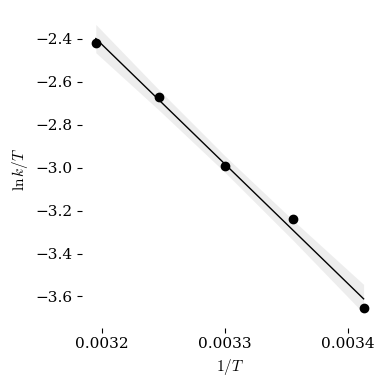

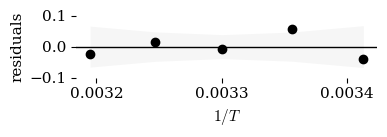

In [170]:
slope_unc = un.ufloat(slope, slope_stderr)
intercept_unc = un.ufloat(intercept, int_stderr)

### calculate the true intercept 
intercept_true = intercept_unc - slope_unc * x_ave

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  
# print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"The true intercept is {intercept_true:0.2f}")
print()
print(f"rsq = {rsq:0.3f}")

#### calculate y-values using best fit parameters
best_fit_y = slope_unc * x + intercept_true  # ufloat.n gives the nominal value

### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                               # plot data with black circle
plt.plot(x,unp.nominal_values(best_fit_y),"k-")  # plot fit line with black line

#### Create Confidence band upper and lower bounds
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
plt.fill_between(x, fit_up, fit_dn, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth = 0, label="confidence interval")
plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3A-08.pdf")
plt.show()                                       # show plot (and clear)
#
### Plot the residuals
plt.figure(figsize=size).set_figheight(1.5)         # set plot height to 1 inch

# confidence band for residuals
dev = unp.std_devs(best_fit_y) * sigma
plt.fill_between(x, dev, -dev, 
                   color="lightgray", alpha=0.2, zorder = 0,
                   linewidth = 0, label="confidence interval")

# difference between data and line-fit
residuals = y - unp.nominal_values(best_fit_y)    
plt.axhline(0, color='black')                  # plot a horizontal line
plt.plot(x,residuals,"ko")
plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.ylim(-.1,.1)

plt.xlabel(r"${1/T}$")
plt.ylabel(r"residuals")
plt.savefig("plots/3A-09.pdf")
plt.show()




### Band Calculated from Zero

Here we plot the lever arm plot again but add the confidence band. This plot must be calculated using the slope and intercept. The intercept occurs at $x = 0$.  If $1/T$ is zero that means we are at infinite temperature. If I had used the uncertain $\Delta H^\ddagger$ and $\Delta S^\ddagger$ and temperature I would have had to use very high temperture values to approach, but never reach the origin of the $1/T$ $x$-axis. This plot emphasizes the effect of the lever arm well.

slope = -5560.07+/-249.08
The true intercept is 15.37+/-0.82

rsq = 0.994


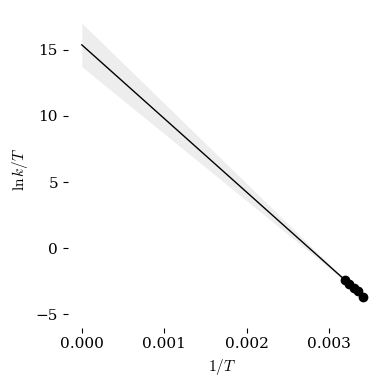

In [169]:
slope_unc = un.ufloat(slope, slope_stderr)
intercept_unc = un.ufloat(intercept, int_stderr)

### calculate the true intercept 
intercept_true = intercept_unc - slope_unc * x_ave

### print a report using the variables
print(f"slope = {slope:0.2f}+/-{slope_stderr:0.2f}")  
# print(f"int = {intercept:0.2f}+/-{int_stderr:0.2f}")  
print(f"The true intercept is {intercept_true:0.2f}")
print()
print(f"rsq = {rsq:0.3f}")

#### calculate y-values using best fit parameters

# use 100 values between zero and max x for smoother plot
x_0 = np.linspace(0,np.max(x),100)                
best_fit_y = slope_unc * x_0 + intercept_true     # uncertain array of line fit

### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                                # plot data with black circle
plt.plot(x_0,unp.nominal_values(best_fit_y),"k-") # plot fit line from zero

#### Create Confidence band upper and lower bounds
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
plt.fill_between(x_0, fit_up, fit_dn, 
                color="lightgray", alpha=0.4, zorder = 0,
                linewidth = 0, label="confidence interval")
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.ylim(-6,18)

plt.savefig("plots/3A-10.pdf")
plt.show()                                       # show plot (and clear)

